# Code and documentation for YouTube popularity prediction

## Importing some packages

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## Reading the dataset

In [14]:
df=pd.read_csv("US_youtube_trending_data.csv")
df.head()

,video_id,title,publishedAt,channelId,channel_title,category_id,trendingAt,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


## Data cleaning

In [15]:
df = df.drop_duplicates()
df['trending_date']=pd.to_datetime(pd.Series(df['trendingAt'].apply(lambda x:x[:19])))
df['publish_time']=pd.to_datetime(pd.Series(df['publishedAt'].apply(lambda x:x[:19])))
df['description']=df['description'].fillna("")
df['trending days_difference']=df.apply(lambda row: (row.trending_date-row.publish_time).days, axis = 1) 
df['trending days_difference'].replace({-1:0},inplace=True)
pd.options.display.float_format = "{:.2f}".format
df.describe()
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False
df["contains_capitalized"] = df["title"].apply(contains_capitalized_word)
value_counts = df["contains_capitalized"].value_counts().to_dict()
df["contains_capitalized"].value_counts(normalize=True)*100
df["title_length"]= df["title"].apply(lambda x: len(x))
df = df.loc[df['views'] > 0]

## Adding popularity category for a video to the dataset

In [16]:
df['score'] = ((df.comment_count + df.likes)*100/(df.views))

### Cluster the video popularity category with optimum number of cluster

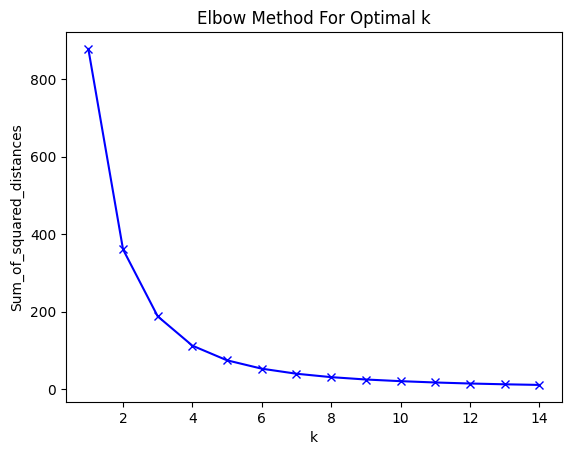

In [17]:
data = df['score'].values
data = data.reshape(-1,1)
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)
warnings.filterwarnings("ignore")
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [18]:
data = df['score'].values.reshape(-1,1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(scaled_features)
df['label'] = kmeans.labels_

## Reading the json file for category name

In [19]:
df['category_name'] = np.nan
df.loc[(df["category_id"] == 1),"category_name"] = 'Film and Animation'
df.loc[(df["category_id"] == 2),"category_name"] = 'Cars and Vehicles'
df.loc[(df["category_id"] == 10),"category_name"] = 'Music'
df.loc[(df["category_id"] == 15),"category_name"] = 'Pets and Animals'
df.loc[(df["category_id"] == 17),"category_name"] = 'Sport'
df.loc[(df["category_id"] == 19),"category_name"] = 'Travel and Events'
df.loc[(df["category_id"] == 20),"category_name"] = 'Gaming'
df.loc[(df["category_id"] == 22),"category_name"] = 'People and Blogs'
df.loc[(df["category_id"] == 23),"category_name"] = 'Comedy'
df.loc[(df["category_id"] == 24),"category_name"] = 'Entertainment'
df.loc[(df["category_id"] == 25),"category_name"] = 'News and Politics'
df.loc[(df["category_id"] == 26),"category_name"] = 'How to and Style'
df.loc[(df["category_id"] == 27),"category_name"] = 'Education'
df.loc[(df["category_id"] == 28),"category_name"] = 'Science and Technology'
df.loc[(df["category_id"] == 29),"category_name"] = 'Non Profits and Activism'
df.loc[(df["category_id"] == 43),"category_name"] = 'Shows'

In [20]:
df.head()

,video_id,title,publishedAt,channelId,channel_title,category_id,trendingAt,tags,views,likes,...,ratings_disabled,description,trending_date,publish_time,trending days_difference,contains_capitalized,title_length,score,label,category_name
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,...,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,2020-08-12,2020-08-11 19:20:14,0,True,34,12.69,1,People and Blogs
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,...,False,"While running her own modding shop, Ramya Pare...",2020-08-12,2020-08-11 17:00:10,0,False,60,6.86,2,Gaming
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,...,False,I left youtube for a month and this is what ha...,2020-08-12,2020-08-11 16:34:06,0,True,53,19.32,0,Entertainment
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,...,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,2020-08-12,2020-08-11 16:38:55,0,True,56,6.22,2,Music
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,...,False,Transforming The LaBrant Family's empty white ...,2020-08-12,2020-08-11 15:10:05,0,True,55,4.27,2,How to and Style


In [21]:
c=df.channel_title.value_counts()
c=c[c>50]
titles=list(c.index)

In [22]:
data=df[df['channel_title'].isin(titles)]
data=data.reset_index()
data.drop(['score','dislikes','index','video_id','trending_date','title','category_id','tags','thumbnail_link','description','publish_time', 'publishedAt', 'trendingAt', 'channelId'],axis=1,inplace=True)

In [23]:
le = LabelEncoder()
for i in data.columns:
    if i in ['channel_title','comments_disabled','ratings_disabled','video_error_or_removed','category_name',
           'contains_capitalized']:
        data[i] = le.fit_transform(data[i])
data.head()

,channel_title,views,likes,comment_count,comments_disabled,ratings_disabled,trending days_difference,contains_capitalized,title_length,label,category_name
0,44,2381688,146739,16549,0,0,0,0,60,2,5
1,821,2038853,353787,40221,0,0,0,1,53,0,3
2,782,496771,23251,7647,0,0,0,1,56,2,7
3,476,1123889,45802,2196,0,0,0,1,55,2,6
4,403,470446,47990,4558,0,0,0,1,24,1,6


## Regression for predicting view count

### Train test split

In [24]:
X=data.drop('views',axis=1)
X=X.drop('label',axis=1)
y=data.views
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

X_train:  (79388, 9)
X_test:  (19848, 9)
y_train:  (79388,)
y_test:  (19848,)


### Prediction using Linear Regressor and Random Forest Regressor

In [25]:
model=LinearRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print("Mean Absolute Error on Training Set: ",mean_absolute_error(y_train,model.predict(X_train)))
print("Mean Absolute Error on Testing Set: ",mean_absolute_error(y_test,y_pred))
print("R-Squared Score on Training Set: ",r2_score(y_train,model.predict(X_train)))
print("R-Squared Score on Testing Set: ",r2_score(y_test,y_pred))

Mean Absolute Error on Training Set:  1573658.077830133
Mean Absolute Error on Testing Set:  1531725.2272463753
R-Squared Score on Training Set:  0.7808088228077981
R-Squared Score on Testing Set:  0.8160746093977201


In [26]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print("Mean Absolute Error on Training Set: ",mean_absolute_error(y_train,model.predict(X_train)))
print("Mean Absolute Error on Testing Set: ",mean_absolute_error(y_test,y_pred))
print("R-Squared Score on Training Set: ",r2_score(y_train,model.predict(X_train)))
print("R-Squared Score on Testing Set: ",r2_score(y_test,y_pred))

Mean Absolute Error on Training Set:  233264.91559086685
Mean Absolute Error on Testing Set:  609902.3997886329
R-Squared Score on Training Set:  0.9938993727009715
R-Squared Score on Testing Set:  0.9634212761738946


## Classification to predict popularity level

### Train Test Split

In [27]:
X=data.drop('label',axis=1)
X=X.drop('views',axis=1)
y=data.label
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

X_train:  (79388, 9)
X_test:  (19848, 9)
y_train:  (79388,)
y_test:  (19848,)


### Prediction using Logistic Regression and Random Forest Classifier

In [28]:
model=LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print(score)

0.5582426440951229


In [29]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print(score)


0.8598347440548166
